In [1]:
import re
import pandas as pd

/var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/ipykernel_79210/1566173301.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# extract "Elapsed (wall clock) time" in mm:ss.xx format and "Maximum resident set size (kbytes):"

def extract_time_and_mem(filename):
    with open(filename, 'r') as f:
        content = f.read()
        time = re.search(r'Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (\d+:\d+\.\d+)', content).group(1)
        mem = re.search(r'Maximum resident set size \(kbytes\): (\d+)', content).group(1)
        return time, mem

In [3]:
with open("../circom_compile.out", 'r') as f:
    content = f.read()
    constraints = re.findall(r'non-linear constraints: (\d+)', content)


In [4]:
with open("../ezkl_bench.out", 'r') as f:
    content = f.read()
    rows = re.findall(r'model uses (\d+) rows', content)

In [5]:
# read from {circom,ezkl}_bench_{1..7}.out, extract time and memory, and store in a dataframe, split circom and ezkl into two columns, 1-7 into indices

data = []
for i in range(1, 8):
    circom_time, circom_mem = extract_time_and_mem(f'circom_bench_{i}.out')
    ezkl_time, ezkl_mem = extract_time_and_mem(f'ezkl_bench_{i}.out')
    data.append([circom_time, circom_mem, ezkl_time, ezkl_mem])

df = pd.DataFrame(data, columns=['circom_time', 'circom_mem', 'ezkl_time', 'ezkl_mem'])
df.index = range(1, 8)

In [6]:
# Convert time columns to hh:mm:ss format
df['circom_time'] = pd.to_datetime(df['circom_time'], format="%M:%S.%f").dt.strftime("%H:%M:%S")
df['ezkl_time'] = pd.to_datetime(df['ezkl_time'], format="%M:%S.%f").dt.strftime("%H:%M:%S")

# Convert time columns to timedelta
df['circom_time'] = pd.to_timedelta(df['circom_time'])
df['ezkl_time'] = pd.to_timedelta(df['ezkl_time'])

# Convert memory columns to integer
df['circom_mem'] = pd.to_numeric(df['circom_mem'])
df['ezkl_mem'] = pd.to_numeric(df['ezkl_mem'])

In [7]:
df['circom_constrs'] = pd.to_numeric(constraints)
df['ezkl_rows'] = pd.to_numeric(rows)

# remove index 5 and 6

df = df.drop([5, 6])
df

,circom_time,circom_mem,ezkl_time,ezkl_mem,circom_constrs,ezkl_rows
1,0 days 00:04:38,85446120,0 days 00:00:33,2869864,11378432,184408
2,0 days 00:08:44,129358852,0 days 00:00:36,2857136,16867552,224968
3,0 days 00:10:16,136911572,0 days 00:03:08,22516096,23101472,1373720
4,0 days 00:10:50,138164812,0 days 00:03:08,22510672,24725472,1385048
7,0 days 00:11:04,137595576,0 days 00:03:11,22512552,24741472,1392273


In [8]:
df_pct = df.div(df.iloc[-1]).multiply(100)
df_pct

,circom_time,circom_mem,ezkl_time,ezkl_mem,circom_constrs,ezkl_rows
1,41.86747,62.099468,17.277487,12.74784,45.989309,13.245104
2,78.915663,94.013816,18.848168,12.691302,68.175216,16.158325
3,92.771084,99.502888,98.429319,100.015742,93.371453,98.667431
4,97.891566,100.413702,98.429319,99.991649,99.935331,99.481064
7,100.0,100.0,100.0,100.0,100.0,100.0


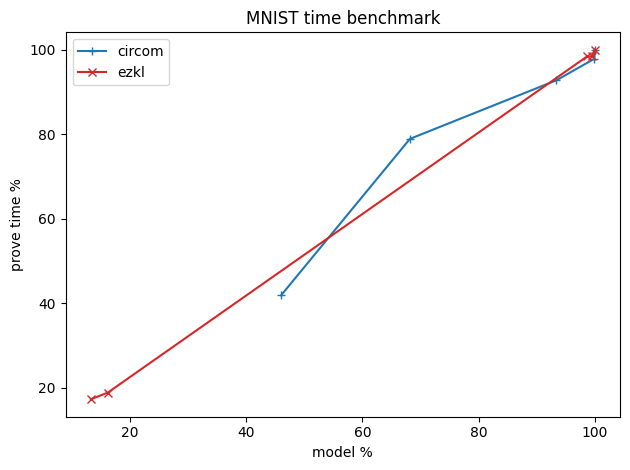

In [9]:
# plot circom_time against circom_pct, ezkl_time against ezkl_pct, on the same graph

import matplotlib.pyplot as plt

plt.title("MNIST time benchmark")
plt.xlabel('model %')
plt.ylabel('prove time %')

plt.plot(df_pct['circom_constrs'], df_pct['circom_time'], color='tab:blue', label='circom', marker='+')
plt.plot(df_pct['ezkl_rows'], df_pct['ezkl_time'], color='tab:red', label='ezkl', marker='x')

plt.legend()
plt.tight_layout()
plt.show()

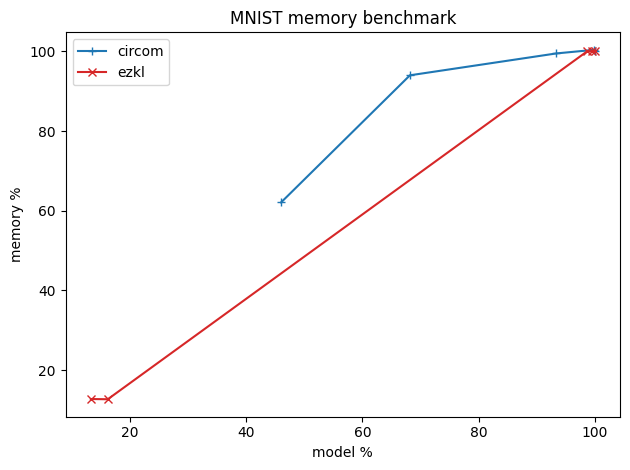

In [10]:
plt.title("MNIST memory benchmark")
plt.xlabel('model %')
plt.ylabel('memory %')

plt.plot(df_pct['circom_constrs'], df_pct['circom_mem'], color='tab:blue', label='circom', marker='+')
plt.plot(df_pct['ezkl_rows'], df_pct['ezkl_mem'], color='tab:red', label='ezkl', marker='x')

plt.legend()
plt.tight_layout()
plt.show()